# Show Mesh Geometry

Plot the cell area and geometry for the uniform and stretched meshes in LFRic-Atmosphere.

In [1]:
import sys
from pathlib import Path

import cartopy.crs as ccrs
import cmocean
import geovista as gv
import pyvista as pv
import swiftascmaps
from aeolus.coord import isel
from aeolus.lfric import load_lfric_mesh, load_lfric_raw
from aeolus.model import lfric
from aeolus.plot import subplot_label_generator
from aeolus.plot.pv import ugrid_mesh_to_gv_mesh
from iris.experimental.geovista import cube_to_polydata

# pv.global_theme.trame.server_proxy_enabled = True
# pv.set_jupyter_backend("trame")

sys.path.append("..")  # noqa

import paths
from common import SIMULATIONS, all_sim_file_label

In [2]:
show_sim = ["hab1_mod_c192p", "hab1_mod_c192s10e"]

## Load the data

In [3]:
dset = {}
for sim_label in show_sim:
    dset[sim_label] = {}
    dset[sim_label]["cell_area"] = load_lfric_raw(
        paths.data_raw
        / SIMULATIONS[sim_label].work_name
        / "1"
        / "run_lfric_atm_*"
        / "lfric_initial.nc",
    ).extract_cube("cell_area")

    dset[sim_label]["mg_meshes"] = {}

    for var_name in ["dynamics", "multigrid_l1", "multigrid_l2", "multigrid_l3"]:
        dset[sim_label]["mg_meshes"][var_name] = load_lfric_mesh(
            str(
                paths.data_raw
                / SIMULATIONS[sim_label].work_name
                / "1"
                / "run_lfric_atm_*"
                / "mesh_*.nc"
            ),
            var_name=var_name,
        )

## Calculate additional diagnostics and create geovista meshes

In [4]:
# Convert cell area to the cell width by taking a square root

for sim_label in show_sim:
    dset[sim_label]["cell_width"] = dset[sim_label]["cell_area"] ** 0.5
    dset[sim_label]["cell_width"].convert_units("km")
    dset[sim_label]["cell_width"].rename("grid_cell_width")
    dset[sim_label]["cell_width"].attributes.pop("invalid_standard_name")

In [5]:
gv_meshes = {}
for sim_label in show_sim:
    gv_meshes[sim_label] = {}
    gv_meshes[sim_label]["cell_width"] = cube_to_polydata(dset[sim_label]["cell_width"])

    for var_name in dset[sim_label]["mg_meshes"]:
        gv_meshes[sim_label][var_name] = ugrid_mesh_to_gv_mesh(
            dset[sim_label]["mg_meshes"][var_name]
        )

## Assemble the figure

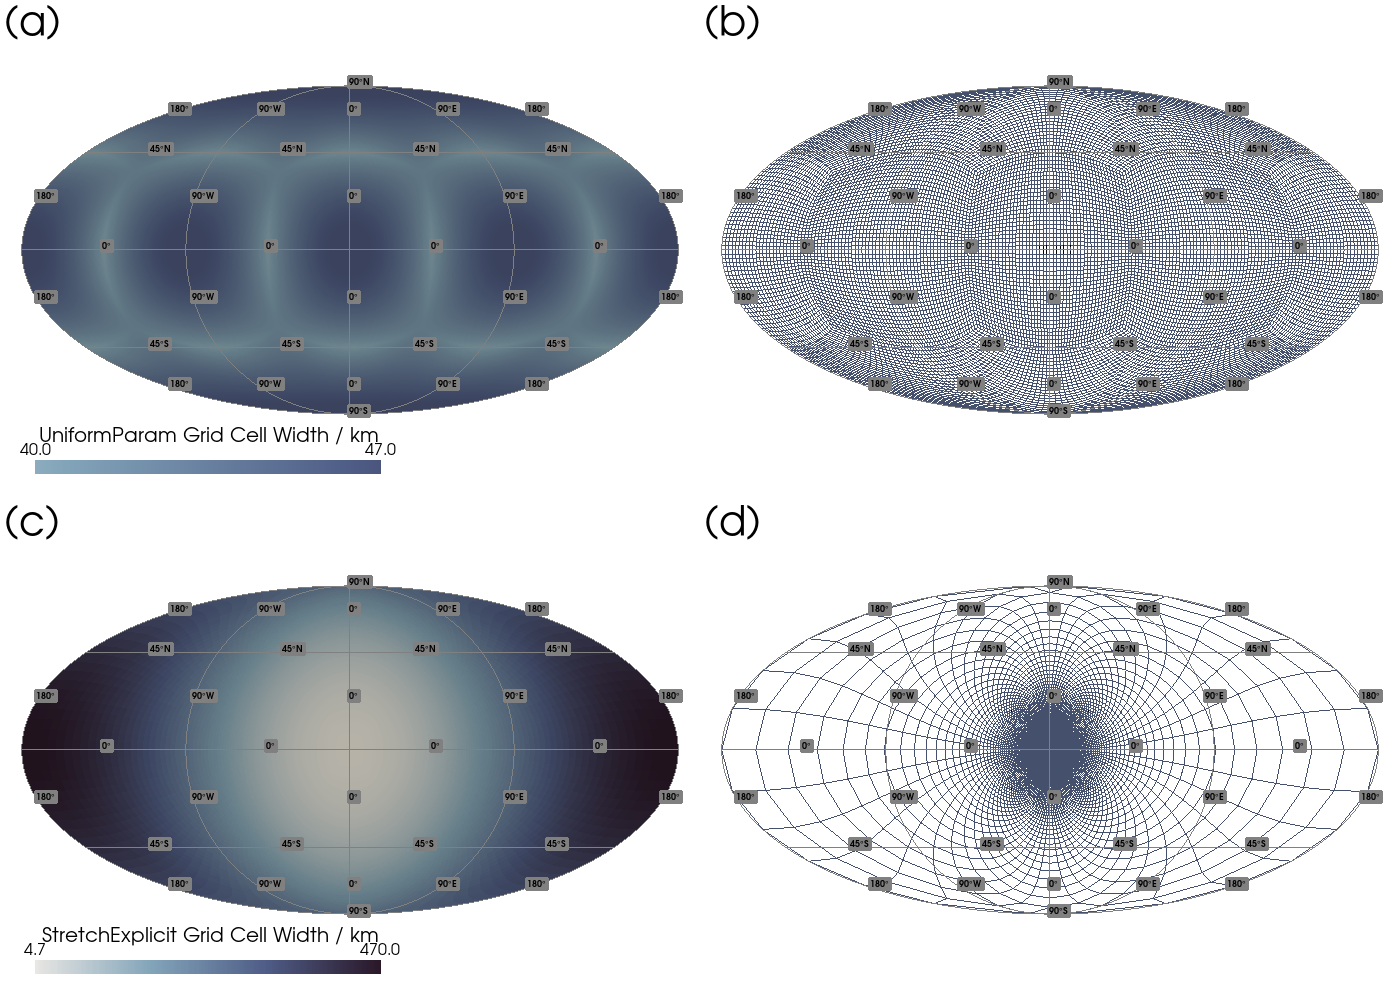

In [6]:
kw_plt = {
    "hab1_mod_c192p": {
        "cmap": cmocean.tools.crop_by_percent(swiftascmaps.midnights_r, 60, "both"),
        "clim": [40, 47],
    },
    "hab1_mod_c192s10e": {
        "cmap": swiftascmaps.midnights_r,
        "clim": [4.7, 470],
    },
}

plotter = gv.GeoPlotter(
    window_size=[1400, 1000], crs=ccrs.Mollweide(), shape=(2, 2), border=False
)
zoom = 1.5
kw_grat = dict(lon_step=90, lat_step=45, mesh_args={"color": "grey"})
letters = subplot_label_generator()

for sim_idx, sim_label in enumerate(show_sim):
    plotter.subplot(sim_idx, 0)
    plotter.add_text(
        f"({next(letters)})",
        position="upper_left",
        font_size=16,
    )
    plotter.add_mesh(
        gv_meshes[sim_label]["cell_width"].copy(),
        show_scalar_bar=True,
        zlevel=0,
        scalar_bar_args={
            "title": f"{SIMULATIONS[sim_label].title} Grid Cell Width / km",
            "title_font_size": 20,
            "label_font_size": 16,
            "shadow": False,
            "n_labels": 2,
            "italic": False,
            "fmt": "%.1f",
            "font_family": "arial",
            "width": 0.5,
            "vertical": False,
            "position_x": 0.05,
            "position_y": 0.05,
        },
        **kw_plt[sim_label],
    )
    plotter.add_graticule(**kw_grat)
    plotter.view_xy()
    plotter.camera.zoom(zoom)

    plotter.subplot(sim_idx, 1)
    plotter.add_text(
        f"({next(letters)})",
        position="upper_left",
        font_size=16,
    )
    plotter.add_mesh(
        gv_meshes[sim_label]["multigrid_l2"],
        style="wireframe",
        color="#586891",
        line_width=0.01,
    )
    plotter.add_graticule(**kw_grat)
    plotter.view_xy()
    plotter.camera.zoom(zoom)


plotter.show(jupyter_backend="static")

plotter.screenshot(paths.figures / f"{all_sim_file_label(show_sim)}__cell_geometry");